# Tester le modèle

Importer les modules nécessaires :

In [1]:
import numpy as np
import cv2
import keras
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

Charger le modèle :

In [2]:
model = keras.models.load_model("best_model_dataflair3.h5")

Définir les variables pour la détection d'arrière-plan et de position du cadre de détection de main :

In [3]:
background = None
accumulated_weight = 0.5

ROI_top = 100
ROI_bottom = 300
ROI_right = 150
ROI_left = 350

Fonction de calcul d'image moyenne d'arrière-plan sur les premières secondes :

In [4]:
def cal_accum_avg(frame, accumulated_weight):

    global background
    
    if background is None:
        background = frame.copy().astype("float")
        return None

    cv2.accumulateWeighted(frame, background, accumulated_weight)

Fonction de segmentation de la main avec contours, à partir de la caméra et de l'arrière-plan :

In [5]:
def segment_hand(frame, threshold=25):
    global background
    
    diff = cv2.absdiff(background.astype("uint8"), frame)

    
    _ , thresholded = cv2.threshold(diff, threshold, 255, cv2.THRESH_BINARY)
    
    # Détecter les contours
    contours, hierarchy = cv2.findContours(thresholded.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # si len(contours) == 0, alors aucun contour n'a été détecté
    if len(contours) == 0:
        return None
    else:
        # Le plus grand contour devrait être la main
        hand_segment_max_cont = max(contours, key=cv2.contourArea)
        
        # Renvoyer le contour de main et sa version threshold
        return (thresholded, hand_segment_max_cont)

Créer un dictionnaire des valeurs (ici les lettres) sur les index obtenus à partir de ``argmax`` pour les plus grandes probabilités :

In [6]:
word_dict = {0:'A',1:'B',2:'C',3:'D',4:'E',5:'F',6:'G',7:'H',8:'I',9:'J',10:'K',11:'L',12:'M',13:'N',14:'O',15:'P',16:'Q',17:'R',18:'S',19:'T',20:'U',21:'V',22:'W',23:'X',24:'Y',25:'Z'}

Tester avec la caméra :

In [8]:
cam = cv2.VideoCapture(0)
num_frames =0
while True:
    ret, frame = cam.read()

    # Faire pivoter l'image
    frame = cv2.flip(frame, 1)

    frame_copy = frame.copy()

    # Définir le cadre
    roi = frame[ROI_top:ROI_bottom, ROI_right:ROI_left]

    gray_frame = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    gray_frame = cv2.GaussianBlur(gray_frame, (9, 9), 0)


    if num_frames < 70:
        
        cal_accum_avg(gray_frame, accumulated_weight)
        
        cv2.putText(frame_copy, "FETCHING BACKGROUND...PLEASE WAIT", (80, 400), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,255), 2)
    
    else: 
        # Segmenter la main
        hand = segment_hand(gray_frame)
        

        # Vérifier si l'on détecte la main
        if hand is not None:
            
            thresholded, hand_segment = hand

            # Dessiner les contours autour de la main
            cv2.drawContours(frame_copy, [hand_segment + (ROI_right, ROI_top)], -1, (255, 0, 0),1)
            
            cv2.imshow("Threshold de la main", thresholded)
            
            thresholded = cv2.resize(thresholded, (64, 64))
            thresholded = cv2.cvtColor(thresholded, cv2.COLOR_GRAY2RGB)
            thresholded = np.reshape(thresholded, (1,thresholded.shape[0],thresholded.shape[1],3))
            
            pred = model.predict(thresholded)
            cv2.putText(frame_copy, word_dict[np.argmax(pred)], (170, 45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
            
    # Dessiner le cadre sur la copie
    cv2.rectangle(frame_copy, (ROI_left, ROI_top), (ROI_right, ROI_bottom), (255,128,0), 3)

    # Compte du nombre de frames
    num_frames += 1

    # Afficher la frame avec main segmentée
    cv2.putText(frame_copy, "Recognition de signe DataFlair", (10, 20), cv2.FONT_ITALIC, 0.5, (51,255,51), 1)
    cv2.imshow("Détection de signe", frame_copy)


    # Fermer avec ESCAPE
    k = cv2.waitKey(1) & 0xFF

    if k == 27:
        break

# Fermer la caméra et détruire les fenêtres
cam.release()
cv2.destroyAllWindows()


## Conclusion

Ce modèle basé sur les contours a un résultat respectable sur les images de test mais est bien plus inégal sur la prise webcam. Certaines lettres bien distinctes comme le L sont bien détectées, d'autres comme le R sont trop similaires à d'autres. La luminosité joue également un grand rôle et peut complètement fausser les résultats.

Exemple avec A, là où les images ont été prises :

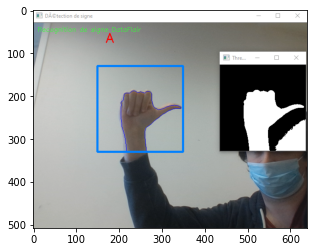

In [11]:
import matplotlib.pyplot as plt

image_A_1 = plt.imread("image_A_1.png")

plt.imshow(image_A_1)

Et dans des conditions de luminosité différentes :

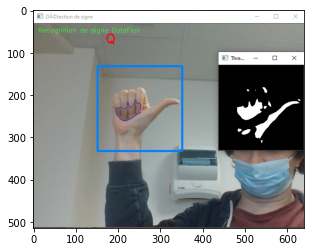

In [12]:
image_A_2 = plt.imread("image_A_2.png")

plt.imshow(image_A_2)

Ce problème pourrait peut-être être compensé avec un plus gros dataset issues de prises à la luminosité variée. Cependant, cette méthode par contours reste limitée pour détecter les positions plus subtiles de la main.